In this project I tried to address the following question: is there any correlation between how good a university is and what kind of neighborhood it is located in. 

To do this I obtained the data containing the list of 1000 World's best universities according to 2018 QS World University ranking.
Using Nominatim function of geopy library I obtained the geographical data: latitude&longitude for each university, and put it all together into a dataframe. 

The next step will be to explore the neighborhoods of universities using Foursquare and the geographical data I have. 

So, let us start by importing the libraries we will need. 

In [2]:
#importing all libraries we will use
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import ssl
import re
import json # library to handle JSON files
#!conda install -c conda-forge geotext --yes
from geotext import GeoText

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="uni_expl")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [29]:
df=pd.read_csv('UNI_data_geo.csv')
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

,University,rank,Country,Size,Latitude,Longitude
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),1,United States,M,42.360091,-71.094160
1,STANFORD UNIVERSITY,2,United States,L,37.427475,-122.169719
2,HARVARD UNIVERSITY,3,United States,L,42.377003,-71.116660
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),4,United States,S,34.137658,-118.125269
4,UNIVERSITY OF OXFORD,5,United Kingdom,L,51.754816,-1.254367


In [38]:
rank_cluster=df
rank_cluster.tail()

,University,rank,Country,Size,Latitude,Longitude
995,VORONEZH STATE UNIVERSITY,801-1000,Russia,L,51.656670,39.206036
996,VYTAUTAS MAGNUS UNIVERSITY,801-1000,Lithuania,M,54.898573,23.914095
997,WEST UNIVERSITY OF TIMISOARA,801-1000,Romania,L,45.747119,21.231615
998,WROCLAW UNIVERSITY OF TECHNOLOGY,801-1000,Poland,L,51.107894,17.061699
999,YEUNGNAM UNIVERSITY,801-1000,South Korea,L,35.832242,128.757575


In [53]:
rank_cluster['rank'].str.replace('-[0-9]+', '', regex=True)
            

0         1  
1         2  
2         3  
3         4  
4         5  
5         6  
6         7  
7         8  
8         9  
9        10  
10       11  
11       12  
12       13  
13       14  
14       15  
15       16  
16       17  
17       18  
18       19  
19       20  
20       21  
21       22  
22       23  
23       24  
24       25  
25       26  
26       27  
27       28  
28       29  
29       30  
        ...  
970       801
971       801
972       801
973       801
974       801
975       801
976       801
977       801
978       801
979       801
980       801
981       801
982       801
983       801
984       801
985       801
986       801
987       801
988       801
989       801
990       801
991       801
992       801
993       801
994       801
995       801
996       801
997       801
998       801
999       801
Name: rank, Length: 997, dtype: object

Now we have the geographical data, let us put the best 500 Universities onto the map. 

Now we use Foursquare to get information about venues located near our universities. 

In [23]:
CLIENT_ID = 'JEVOXOTZ0Z0K0WIU2LAAPMOMHW3ELP0GMEX5EZ4LVCME5RUS' # your Foursquare ID
CLIENT_SECRET = 'XBWSHKXYV3BBQ5PWM4QIYEHVQRAAJZYPAE5M4EUIAUP3ASCI' # your Foursquare Secret
VERSION = '20190720'

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    LIMIT=50
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)   
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['University', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
uni_venues = getNearbyVenues(names=df['University'],latitudes=df['Latitude'],longitudes=df['Longitude'],radius=600)

MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT)
STANFORD UNIVERSITY
HARVARD UNIVERSITY
CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH)
UNIVERSITY OF OXFORD
UNIVERSITY OF CAMBRIDGE
ETH ZURICH (SWISS FEDERAL INSTITUTE OF TECHNOLOGY)
IMPERIAL COLLEGE LONDON
UNIVERSITY OF CHICAGO
UCL (UNIVERSITY COLLEGE LONDON)
NATIONAL UNIVERSITY OF SINGAPORE (NUS)
NANYANG TECHNOLOGICAL UNIVERSITY (NTU)
PRINCETON UNIVERSITY
CORNELL UNIVERSITY
YALE UNIVERSITY
COLUMBIA UNIVERSITY
TSINGHUA UNIVERSITY
UNIVERSITY OF EDINBURGH
UNIVERSITY OF PENNSYLVANIA
UNIVERSITY OF MICHIGAN
JOHNS HOPKINS UNIVERSITY
ÉCOLE POLYTECHNIQUE FÉDÉRALE DE LAUSANNE (EPFL)
THE UNIVERSITY OF TOKYO
AUSTRALIAN NATIONAL UNIVERSITY (ANU)
UNIVERSITY OF HONG KONG (HKU)
DUKE UNIVERSITY
UNIVERSITY OF CALIFORNIA, BERKELEY (UCB)
UNIVERSITY OF TORONTO
THE UNIVERSITY OF MANCHESTER
PEKING UNIVERSITY
KING'S COLLEGE LONDON (KCL)
UNIVERSITY OF CALIFORNIA, LOS ANGELES (UCLA)
NORTHWESTERN UNIVERSITY
KYOTO UNIVERSITY
SEOUL NATIONAL UNIVERSITY (SNU)
THE HONG KONG 

UNIVERSITÉ GRENOBLE-ALPES (UGA)
UNIVERSITY OF OTTAWA
TONGJI UNIVERSITY
BEIJING NORMAL UNIVERSITY
NATIONAL YANG MING UNIVERSITY
UNIVERSITY OF INDONESIA
INDIAN INSTITUTE OF TECHNOLOGY KHARAGPUR (IITKGP)
SUN YAT-SEN UNIVERSITY
UNIVERSITÉ PARIS DIDEROT - PARIS 7
UNIVERSITAT POMPEU FABRA
BAUMAN MOSCOW STATE TECHNICAL UNIVERSITY
UNIVERSITÄT ERLANGEN-NÜRNBERG
UNIVERSITÉ PARIS 1 PANTHÉON-SORBONNE
HERIOT-WATT UNIVERSITY
LINKÖPING UNIVERSITY
ECOLE NORMALE SUPÉRIEURE DE CACHAN
BIRKBECK COLLEGE, UNIVERSITY OF LONDON
UNIVERSITÄT KÖLN
NATIONAL TAIWAN NORMAL UNIVERSITY
DEAKIN UNIVERSITY
UNIVERSIDAD POLITECNICA DE VALENCIA
YESHIVA UNIVERSITY
MOSCOW INSTITUTE OF PHYSICS AND TECHNOLOGY STATE UNIVERSITY
UNIVERSITY AT BUFFALO SUNY
XI'AN JIAOTONG UNIVERSITY
GWANGJU INSTITUTE OF SCIENCE AND TECHNOLOGY (GIST)
KHALIFA UNIVERSITY
CHARLES UNIVERSITY
LINCOLN UNIVERSITY
EWHA WOMANS UNIVERSITY
TILBURG UNIVERSITY
HIROSHIMA UNIVERSITY
UNIVERSITY OF TARTU
INDIANA UNIVERSITY BLOOMINGTON
UNIVERSITY OF BRUNEI DARUSSALAM

COVENTRY UNIVERSITY
DALIAN UNIVERSITY OF TECHNOLOGY
MASARYK UNIVERSITY
SARAJEVO SCHOOL OF SCIENCE AND TECHNOLOGY
TOKYO UNIVERSITY OF AGRICULTURE AND TECHNOLOGY
UNIVERSITÀ DEGLI STUDI DI TORINO (UNITO)
UNIVERSITÄT REGENSBURG
UNIVERSITÉ PARIS DESCARTES
COLLEGE OF WILLIAM & MARY
IMAM ABDULRAHMAN BIN FAISAL UNIVERSITY (IAU) (FORMERLY UNIVERSITY OF DAMMAM)
INSTITUTO TECNOLÓGICO DE BUENOS AIRES (ITBA)
KONKUK UNIVERSITY
UNIVERSIDAD ANAHUAC
UNIVERSIDADE DE SANTIAGO DE COMPOSTELA
UNIVERSITÀ DEGLI STUDI DI PAVIA (UNIPV)
UNIVERSITÄT LEIPZIG
UNIVERSITY OF GUELPH
UNIVERSITY OF MASSACHUSETTS, BOSTON
UNIVERSITY OF OREGON
VILNIUS GEDIMINAS TECHNICAL UNIVERSITY
HALLYM UNIVERSITY
KINGSTON UNIVERSITY, LONDON
MICHIGAN TECHNOLOGICAL UNIVERSITY
MURDOCH UNIVERSITY
UNIVERSIDAD DE SALAMANCA
UNIVERSIDAD DE SAN ANDRÉS
UNIVERSITY OF BALAMAND
UNIVERSITY OF BRADFORD
UNIVERSITY OF HULL
UNIVERSITY OF HYDERABAD
UNIVERSITY OF MISSOURI, COLUMBIA
UNIVERSITY OF MONS
ALTAI STATE UNIVERSITY
BAR-ILAN UNIVERSITY
CENTRAL QUEEN

KYOTO INSTITUTE OF TECHNOLOGY
KYUSHU INSTITUTE OF TECHNOLOGY
LODZ UNIVERSITY OF TECHNOLOGY
LOYOLA UNIVERSITY CHICAGO
MANCHESTER METROPOLITAN UNIVERSITY
MARQUETTE UNIVERSITY
MEIJI UNIVERSITY
MIAMI UNIVERSITY
MULTIMEDIA UNIVERSITY (MMU)
MUSTANSIRIYAH UNIVERSITY
NATIONAL CHUNG CHENG UNIVERSITY
NICOLAUS COPERNICUS UNIVERSITY
NORTH-WEST UNIVERSITY
NOTRE DAME UNIVERSITY - LOUAIZE (NDU)
NOTTINGHAM TRENT UNIVERSITY
NOVOSIBIRSK STATE TECHNICAL UNIVERSITY
OCHANOMIZU UNIVERSITY
OHIO UNIVERSITY
PLEKHANOV RUSSIAN UNIVERSITY OF ECONOMICS
PONTIFICIA UNIVERSIDAD CATÓLICA DEL ECUADOR
PONTIFÍCIA UNIVERSIDADE CATÓLICA DO RIO GRANDE DO SUL
POZNAN UNIVERSITY OF TECHNOLOGY
PRINCE OF SONGKLA UNIVERSITY
RHODES UNIVERSITY
RIGA STRADINS UNIVERSITY
RITSUMEIKAN UNIVERSITY
RYERSON UNIVERSITY
SAITAMA UNIVERSITY
SAN DIEGO STATE UNIVERSITY
SAVITRIBAI PHULE PUNE UNIVERSITY
SEOUL NATIONAL UNIVERSITY OF SCIENCE AND TECHNOLOGY
SEPULUH NOPEMBER INSTITUTE OF TECHNOLOGY
SHAHID BEHESHTI UNIVERSITY TEHRAN
SHINSHU UNIVERSITY
S

In [31]:
uni_venues.head()

,University,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Zesiger Sports And Fitness Center,42.358802,-71.095888,Gym / Fitness Center
1,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Flour Bakery + Cafe,42.361123,-71.096521,Bakery
2,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Central Bottle Wine + Provisions,42.361246,-71.096741,Wine Shop
3,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,MIT Johnson Athletics Center (Building W34),42.358856,-71.095932,College Gym
4,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Cafe Luna,42.362875,-71.094341,Café


In [32]:
print('There are {} unique categories.'.format(len(uni_venues['Venue Category'].unique())))

There are 591 unique categories.


Now we do the onehot encoding of the venues data, that is what we will play with later.

In [33]:
# one hot encoding
uni_onehot = pd.get_dummies(uni_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uni_onehot['University'] = uni_venues['University'] 

# move neighborhood column to the first column
fixed_columns = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns]

uni_onehot.shape

(25371, 591)

In [34]:
uni_grouped = uni_onehot.groupby('University').mean().reset_index()
uni_grouped.head()


,University,Zoo,ATM,Acai House,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant
0,AALBORG UNIVERSITY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AALTO UNIVERSITY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AARHUS UNIVERSITY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ABERYSTWYTH UNIVERSITY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABO AKADEMI UNIVERSITY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.model_selection import train_test_split

We make a separate small table with rank information + pick the best universities -- we will need them later. 

In [1274]:
uni_rank=uni_EU[['University','Rank Cluster']]
uni_rank.head()
uni_best=uni_rank[uni_rank['Rank Cluster']==0]

We use PCA to reduce overfitting due to high dimension.

In [1325]:
from sklearn.decomposition import PCA
n=3
pca = PCA(n_components=n)
X=uni_grouped.drop('University', 1)
principalComponents = pca.fit_transform(X)
principalComponents-= principalComponents.min()
principalComponents /= principalComponents.max()
COL=list()
for index in range(n):
    COL.append('p'+str(index+1))
principalDf = pd.DataFrame(data = principalComponents
             , columns =COL)
principalDf.insert(0, 'University', uni_grouped['University'])
principalDf.head(5)

,University,p1,p2,p3
0,AALBORG UNIVERSITY,0.430380,0.451365,0.432795
1,AALTO UNIVERSITY,0.424769,0.694576,0.511137
2,AARHUS UNIVERSITY,0.416151,0.488726,0.475472
3,ABERYSTWYTH UNIVERSITY,0.179501,0.173755,0.957268
4,AL-FARABI KAZAKH NATIONAL UNIVERSITY,0.634930,0.512100,0.510088


Here we are preparing our data for making a decision tree model. 
Here I would like to emphasize the following: 
there is NO significant correlation between location and university ranking, 
still, even a very bad model is able to tell us something, as we will see further. 

In [1326]:
uni_tree=uni_rank
uni_tree=uni_tree.join(principalDf.set_index('University'), on='University')


In [1327]:
uni_tree.dropna(inplace=True)
uni_tree.head()

,University,Rank Cluster,p1,p2,p3
4,UNIVERSITY OF OXFORD,0,0.454296,0.406083,0.554982
5,UNIVERSITY OF CAMBRIDGE,0,0.297116,0.436615,0.485690
6,ETH ZURICH (SWISS FEDERAL INSTITUTE OF TECHNOL...,0,0.538363,0.451960,0.438458
7,IMPERIAL COLLEGE LONDON,0,0.502584,0.459397,0.434305
9,UCL (UNIVERSITY COLLEGE LONDON),0,0.450797,0.436988,0.468345


In [1134]:
 from sklearn.tree import DecisionTreeClassifier

In [1328]:
X=uni_tree.drop(['University','Rank Cluster'],1)
y=uni_tree[['Rank Cluster']].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1329]:
for k in range(2,20):
    clf = DecisionTreeClassifier(random_state=3, max_depth=k)
    clf = clf.fit(X_train, y_train)
    yy=clf.predict(X_train)
    print(accuracy_score(yy,y_train))

0.23837209302325582
0.27906976744186046
0.3372093023255814
0.4127906976744186
0.5058139534883721
0.5581395348837209
0.6337209302325582
0.7267441860465116
0.7790697674418605
0.8255813953488372
0.8837209302325582
0.9244186046511628
0.9593023255813954
0.9883720930232558
1.0
1.0
1.0
1.0


In [1330]:
clf = DecisionTreeClassifier(random_state=3, max_depth=4)
clf = clf.fit(X_train, y_train)
yy=clf.predict(X_train)

In [1331]:
y_hat=clf.predict(X_test)

In [1332]:
y_hat

array([2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 1, 1, 2, 2, 2, 4, 2, 2, 2, 2, 3,
       2, 7, 2, 2, 7, 2, 2, 9, 1, 2, 7, 1, 9, 2, 2, 2, 2, 2, 5, 2, 3, 3])

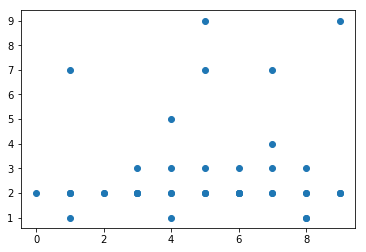

In [1333]:
plt.scatter(y_test, y_hat)

In [1120]:
from sklearn.metrics import accuracy_score

In [1334]:
accuracy_score(y_test, y_hat)

0.13636363636363635

In [1335]:
y_guessed=clf.predict(X)

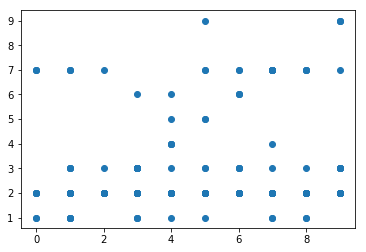

In [1336]:
plt.scatter(y,y_guessed)

In [1223]:
uni_tree.insert(0,'Predicted Cluster',y_guessed)
cluster4=uni_tree[uni_tree['Rank Cluster'].isin([4])]
cluster5=uni_tree[uni_tree['Rank Cluster'].isin([5])]


In [1224]:
cluster4

,Predicted Cluster,University,Rank Cluster,p1,p2,p3,p4,p5,p6,p7
199,5,STOCKHOLM UNIVERSITY,4,0.569081,0.442172,0.437705,0.406489,0.395783,0.462186,0.408361
203,4,RADBOUD UNIVERSITY NIJMEGEN,4,0.590455,0.695342,0.277603,0.445663,0.431528,0.314446,0.506752
205,4,UNIVERSIDAD COMPLUTENSE DE MADRID (UCM),4,0.384547,0.355024,0.267196,0.474075,1.000000,0.396900,0.586101
210,5,MAASTRICHT UNIVERSITY,4,0.333306,0.366779,0.349737,0.355262,0.401610,0.364865,0.334390
216,3,SAPIENZA - UNIVERSITÀ DI ROMA,4,0.438470,0.337015,0.355563,0.413505,0.364948,0.363324,0.379489
217,5,LOUGHBOROUGH UNIVERSITY,4,0.356299,0.346758,0.329658,0.345843,0.415680,0.355221,0.352423
219,4,AL-FARABI KAZAKH NATIONAL UNIVERSITY,4,0.369075,0.405175,0.293808,0.393222,0.426773,0.411728,0.328534
220,5,SCIENCES PO PARIS,4,0.394131,0.332441,0.324535,0.342792,0.395529,0.382664,0.371847
222,3,UNIVERSITÄT HAMBURG,4,0.470164,0.343353,0.419027,0.369398,0.382240,0.384725,0.373243
223,3,UNIVERSITY OF ANTWERP,4,0.261745,0.418940,0.411922,0.515383,0.364902,0.361386,0.418661


In [1225]:
cluster5

,Predicted Cluster,University,Rank Cluster,p1,p2,p3,p4,p5,p6,p7
252,5,TECHNISCHE UNIVERSITÄT DARMSTADT,5,0.392822,0.379515,0.341019,0.403448,0.395698,0.402023,0.364648
253,3,UNIVERSIDAD CARLOS III DE MADRID,5,0.356126,0.345472,0.312782,0.416715,0.372187,0.348018,0.388229
254,5,RHEINISCHE FRIEDRICH-WILHELMS-UNIVERSITÄT BONN,5,0.433359,0.350035,0.391800,0.375397,0.396172,0.406604,0.343729
259,3,"NATIONAL UNIVERSITY OF IRELAND, GALWAY (NUIG)",5,0.278472,0.443954,0.534209,0.422109,0.362872,0.344665,0.427370
260,5,UNIVERSITÄT STUTTGART,5,0.385870,0.370515,0.301228,0.359351,0.402565,0.375739,0.287399
262,3,ECOLE DES PONTS PARISTECH,5,0.288209,0.374153,0.357403,0.383591,0.373716,0.423600,0.449802
267,3,UNIVERSITY OF STRATHCLYDE,5,0.325176,0.392281,0.370304,0.556032,0.340208,0.358016,0.409720
268,5,UNIVERSITY OF EAST ANGLIA (UEA),5,0.538432,0.425454,0.495889,0.486412,0.422873,0.421167,0.439276
269,3,UNIVERSITY OF GOTHENBURG,5,0.416736,0.330094,0.348745,0.366610,0.365940,0.341705,0.389212
272,3,UNIVERSITY OF DUNDEE,5,0.366706,0.356836,0.344470,0.500326,0.361685,0.374882,0.390754


In [1186]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1187]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['University']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
uni_venues_sorted = pd.DataFrame(columns=columns)
uni_venues_sorted['University'] = uni_grouped['University']

for ind in np.arange(uni_grouped.shape[0]):
    uni_venues_sorted.iloc[ind, 1:] = return_most_common_venues(uni_grouped.iloc[ind, :], num_top_venues)

uni_venues_sorted.head()

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AALBORG UNIVERSITY,Bus Station,Gym,Pizza Place,Café,Empanada Restaurant
1,AALTO UNIVERSITY,Cafeteria,Fast Food Restaurant,Bus Stop,Restaurant,Café
2,AARHUS UNIVERSITY,Bar,Science Museum,Park,Student Center,Eastern European Restaurant
3,AL-FARABI KAZAKH NATIONAL UNIVERSITY,Gym,Cosmetics Shop,Gym / Fitness Center,Garden,Falafel Restaurant
4,ASTON UNIVERSITY,Pub,Sandwich Place,Café,Park,Coffee Shop


In [1193]:
uni_venues_sorted[uni_venues_sorted['University'].isin(cluster4['University'])]

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,AL-FARABI KAZAKH NATIONAL UNIVERSITY,Gym,Cosmetics Shop,Gym / Fitness Center,Garden,Falafel Restaurant
49,LOUGHBOROUGH UNIVERSITY,College Library,Hotel,Pub,Stadium,Gym / Fitness Center
53,MAASTRICHT UNIVERSITY,Italian Restaurant,Sandwich Place,Bistro,Metro Station,Coffee Shop
63,NOVOSIBIRSK STATE UNIVERSITY,College Gym,Coffee Shop,Plaza,College Quad,Gym Pool
71,RADBOUD UNIVERSITY NIJMEGEN,Bus Stop,Bar,Café,Paper / Office Supplies Store,College Cafeteria
74,ROYAL HOLLOWAY UNIVERSITY OF LONDON,Café,Pub,Coffee Shop,College Cafeteria,Grocery Store
78,SAINT-PETERSBURG STATE UNIVERSITY,Gym / Fitness Center,Science Museum,Arcade,Museum,Coffee Shop
79,SAPIENZA - UNIVERSITÀ DI ROMA,Pizza Place,Bistro,Hotel,Bar,Café
80,SCIENCES PO PARIS,French Restaurant,Hotel,Italian Restaurant,Tea Room,Café
85,STOCKHOLM UNIVERSITY,Café,Diner,College Gym,Bus Station,Bookstore


In [1194]:
uni_venues_sorted[uni_venues_sorted['University'].isin(cluster5['University'])]

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,BAUMAN MOSCOW STATE TECHNICAL UNIVERSITY,Hookah Bar,Coffee Shop,Café,Sandwich Place,Historic Site
20,ECOLE DES PONTS PARISTECH,Hotel,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Bar
59,"NATIONAL UNIVERSITY OF IRELAND, GALWAY (NUIG)",Coffee Shop,Café,Gym,Bar,Gastropub
73,RHEINISCHE FRIEDRICH-WILHELMS-UNIVERSITÄT BONN,Café,Plaza,Italian Restaurant,Cocktail Bar,Museum
83,"SOAS - SCHOOL OF ORIENTAL AND AFRICAN STUDIES,...",Coffee Shop,Exhibit,Café,Park,Science Museum
91,TECHNISCHE UNIVERSITÄT DARMSTADT,Pub,Sushi Restaurant,Bus Stop,Steakhouse,Gastropub
102,TOMSK STATE UNIVERSITY,Bakery,Café,Convenience Store,Coffee Shop,Middle Eastern Restaurant
107,UNIVERSIDAD CARLOS III DE MADRID,Grocery Store,Tapas Restaurant,American Restaurant,Gastropub,Sandwich Place
117,UNIVERSITAT POLITÈCNICA DE CATALUNYA,Spanish Restaurant,Hot Dog Joint,Athletics & Sports,Pizza Place,Mediterranean Restaurant
118,UNIVERSITAT POMPEU FABRA,Bakery,Burger Joint,Café,Supermarket,Spanish Restaurant


In [1196]:
uni_venues_sorted[uni_venues_sorted['University'].isin(uni_best['University'])]

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,ETH ZURICH (SWISS FEDERAL INSTITUTE OF TECHNOL...,Swiss Restaurant,Hotel,Italian Restaurant,Plaza,Bar
31,IMPERIAL COLLEGE LONDON,Science Museum,Exhibit,Garden,Café,Polish Restaurant
40,KING'S COLLEGE LONDON (KCL),Theater,Hotel,Restaurant,Japanese Restaurant,Cocktail Bar
48,LONDON SCHOOL OF ECONOMICS AND POLITICAL SCIEN...,Coffee Shop,Pub,Hotel,Theater,Restaurant
96,THE UNIVERSITY OF MANCHESTER,Chinese Restaurant,Bar,Grocery Store,Music Venue,Bus Stop
104,UCL (UNIVERSITY COLLEGE LONDON),Coffee Shop,Sandwich Place,Café,Exhibit,Bookstore
130,UNIVERSITY OF CAMBRIDGE,Coffee Shop,Fast Food Restaurant,Bus Station,Electronics Store,Diner
136,UNIVERSITY OF EDINBURGH,Coffee Shop,Pub,Museum,Bar,Indian Restaurant
155,UNIVERSITY OF OXFORD,Coffee Shop,Café,Pub,Sandwich Place,Bookstore
213,ÉCOLE POLYTECHNIQUE FÉDÉRALE DE LAUSANNE (EPFL),Hotel,Café,Discount Store,Italian Restaurant,Science Museum
